In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

In [3]:
import os
import cv2
import numpy as np
path = 'D:/Joshwin/research papers/dataset/tuberculosis dataset/TB_Chest_Radiography_Database'
classes = {'Normal': 0, 'Tuberculosis': 1}
def preprocess_images(path, classes):
    x ,y =[],[]
    for key in classes:
        pth = os.path.join(path, key)
        for i in os.listdir(pth):
            img = cv2.imread(os.path.join(pth, i), 0)
            img = cv2.resize(img, (200, 200))
            img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
            x.append(img.flatten())
            y.append(classes[key])
    return np.array(x), np.array(y)

x, y = preprocess_images(path, classes)

In [4]:
class_counts = pd.Series(y).value_counts()
print("Class Distribution:")
print(class_counts)

Class Distribution:
0    3500
1    1036
Name: count, dtype: int64


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Stratified K-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store model evaluation scores
accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, val_idx in kfold.split(x, y):
    # Split data into training and validation sets
    x_train, y_train = x[train_idx], y[train_idx]
    x_val, y_val = x[val_idx], y[val_idx]

    # Oversample the minority class in the training set
    oversample = RandomOverSampler()
    x_train_resampled, y_train_resampled = oversample.fit_resample(x_train, y_train)



In [6]:
# Oversample the minority class in the training set
oversample = RandomOverSampler()
x_train_resampled, y_train_resampled = oversample.fit_resample(x_train, y_train)

In [7]:
x_train_resampled

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [8]:
y_train_resampled

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
# Class distribution check after sampling
class_counts_sampled = pd.Series(y_train_resampled).value_counts()
print("\nClass Distribution after sampling:")
print(class_counts_sampled)



Class Distribution after sampling:
0    2800
1    2800
Name: count, dtype: int64


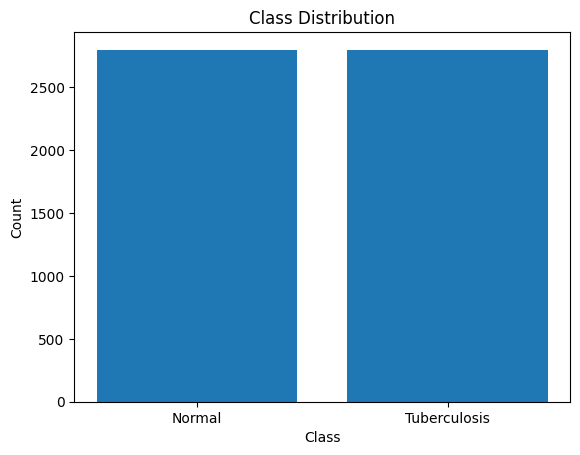

In [10]:
plt.bar(class_counts.index, class_counts_sampled.values)
plt.xticks(class_counts.index, ['Normal', 'Tuberculosis'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [11]:
print("Image Statistics:")
print("Mean Pixel Value:", np.mean(x))
print("Median Pixel Value:", np.median(x))
print("Standard Deviation of Pixel Values:", np.std(x))

Image Statistics:
Mean Pixel Value: 0.5852341490299824
Median Pixel Value: 1.0
Standard Deviation of Pixel Values: 0.49268158057627176


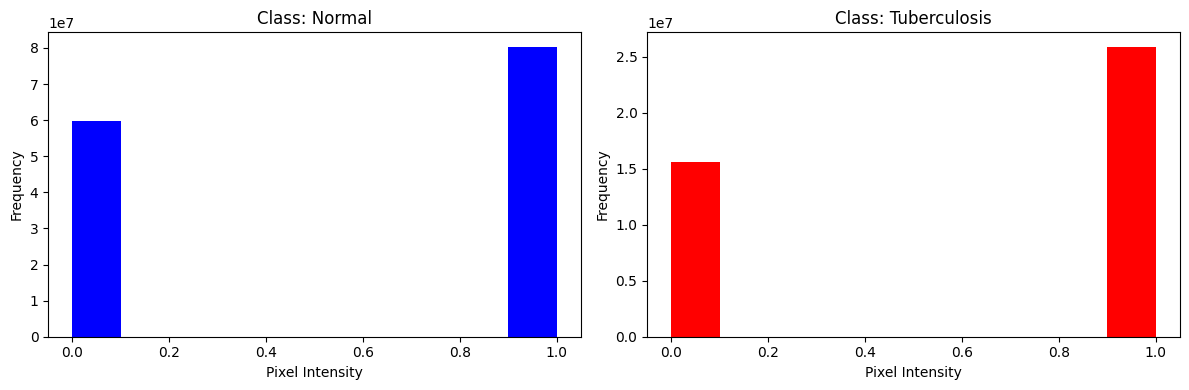

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axes.flat):
    ax.hist(x[y == i].flatten(), bins=10, color=['blue', 'red'][i])
    ax.set_title('Class: {}'.format(['Normal', 'Tuberculosis'][i]))
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

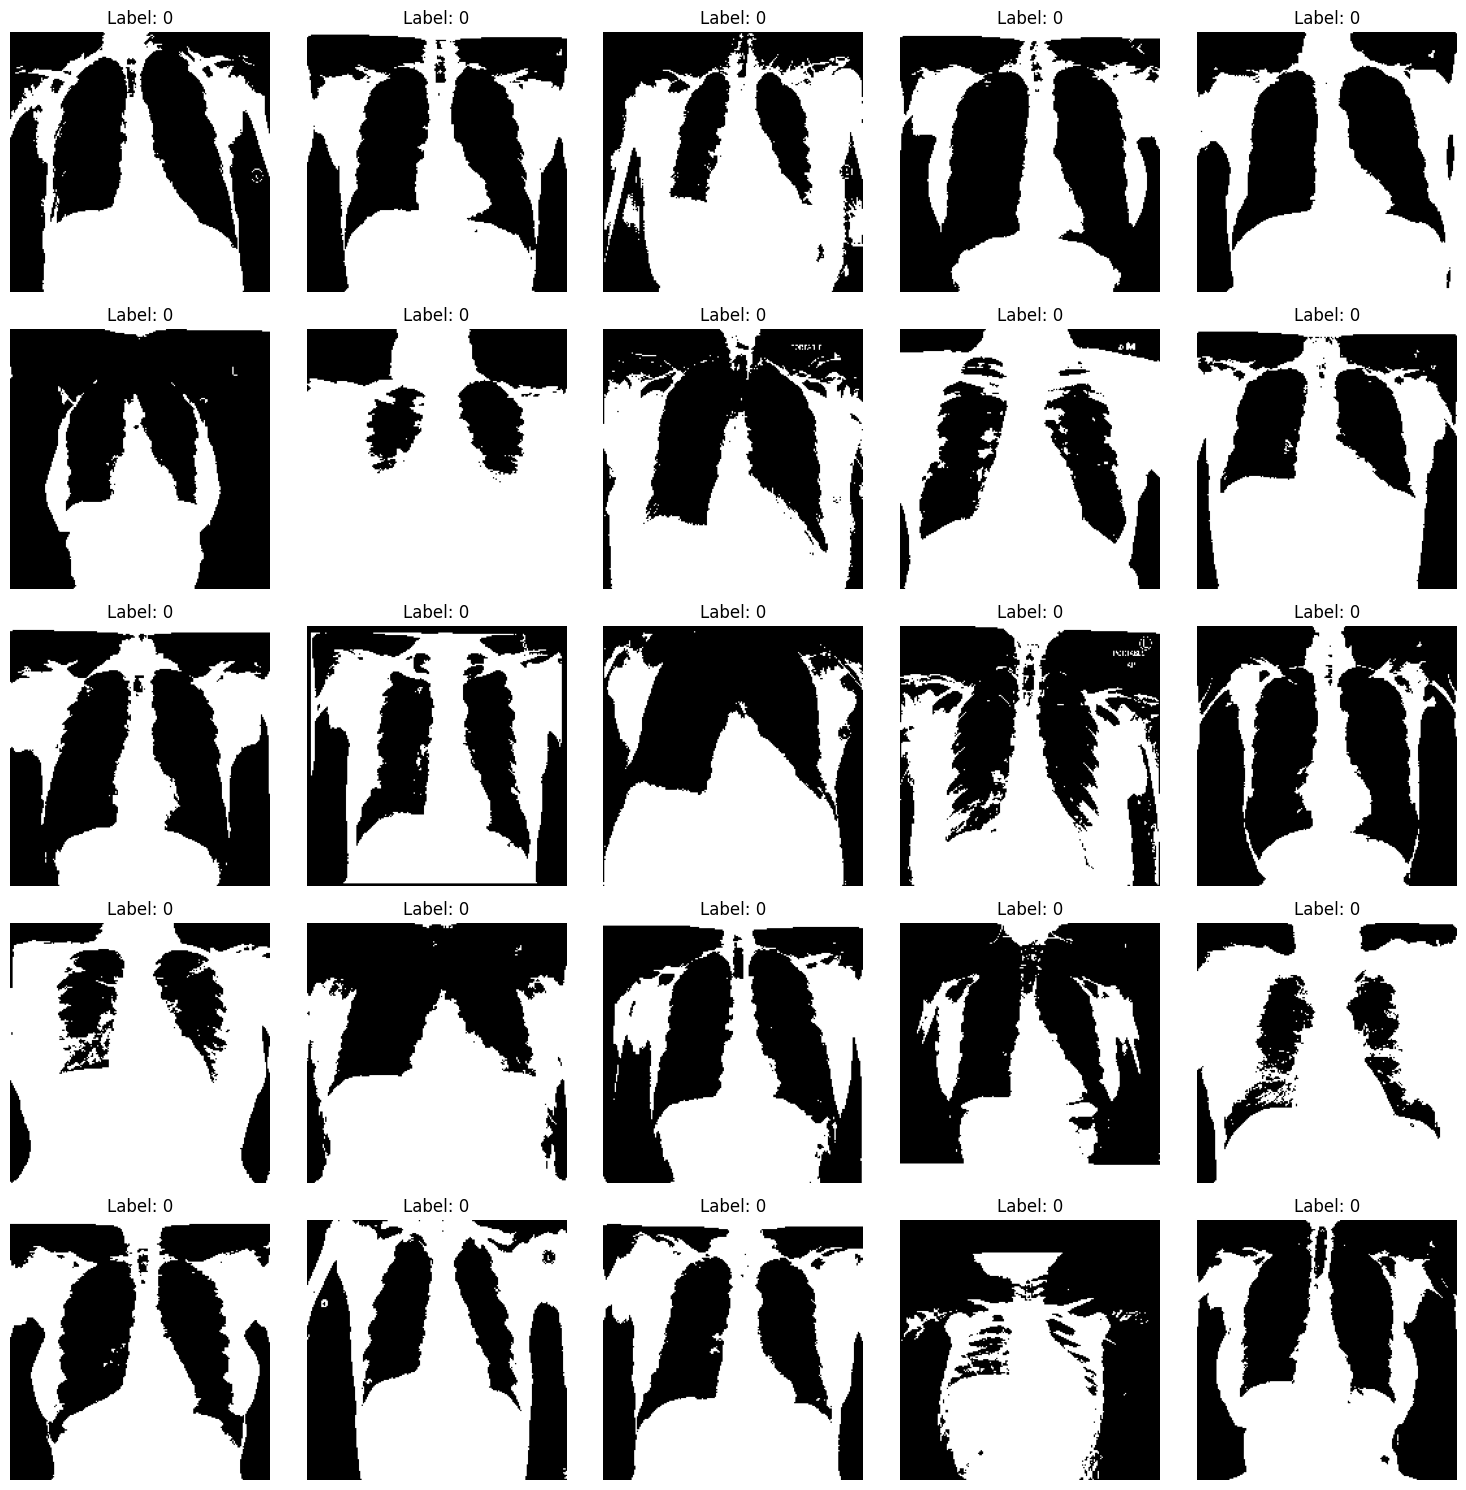

In [13]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, labels, num_images=25):
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.ravel()
    
    for i, (image, label) in enumerate(zip(images[:num_images], labels[:num_images])):
        axes[i].imshow(image.reshape(200, 200), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Reshape the oversampled images to their original shape
x_resampled_reshaped = [img.reshape(200, 200) for img in x_train]

# Plot the first 25 oversampled images
plot_images(x_resampled_reshaped, y_train_resampled)

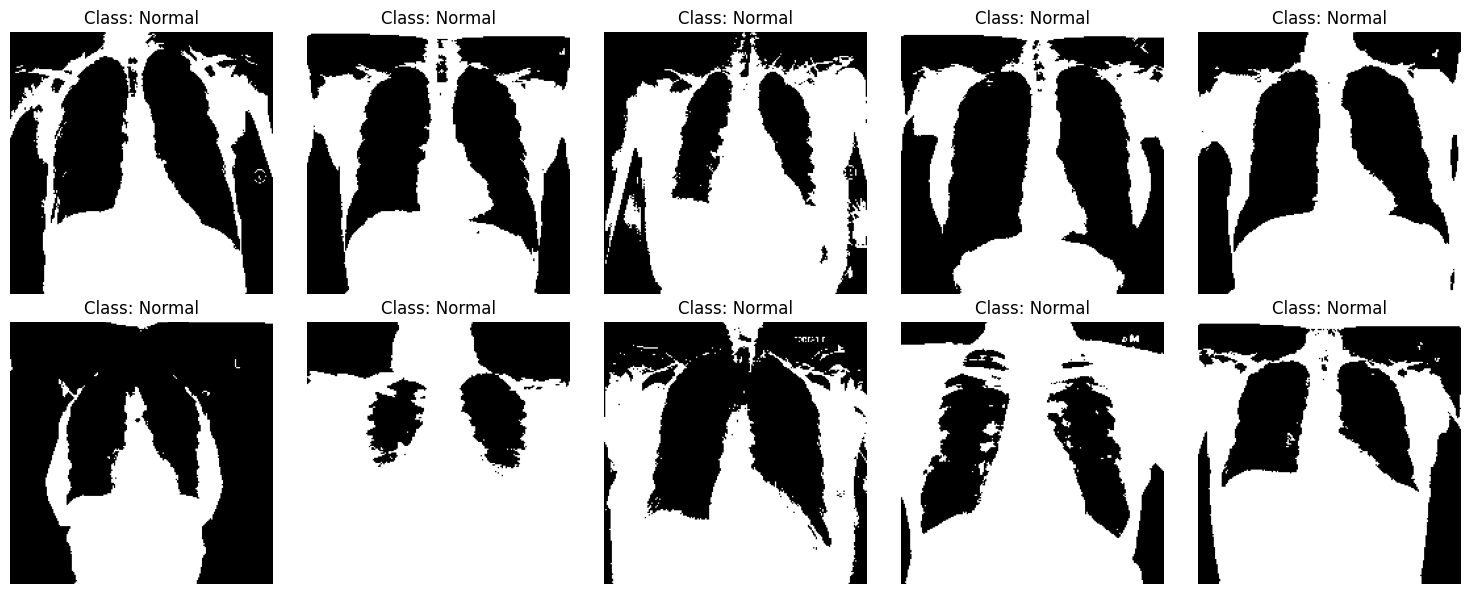

In [14]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Sample Images with Annotations
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].reshape(200, 200), cmap='gray')
    ax.set_title('Class: {}'.format(['Normal', 'Tuberculosis'][y[i]]))
    ax.axis('off')
plt.tight_layout()
plt.show()


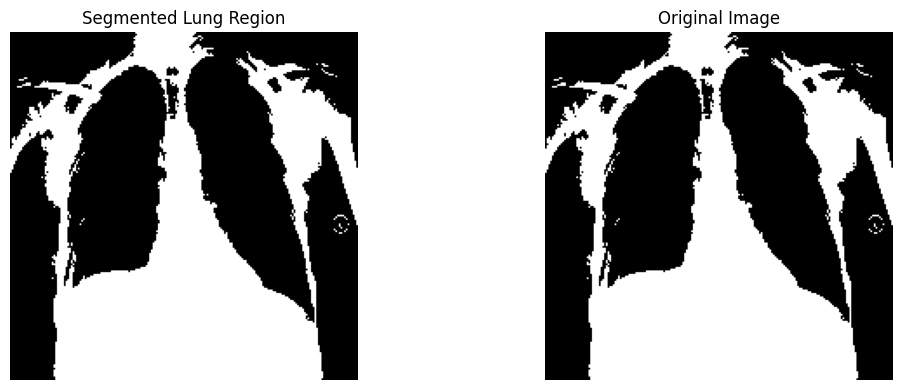

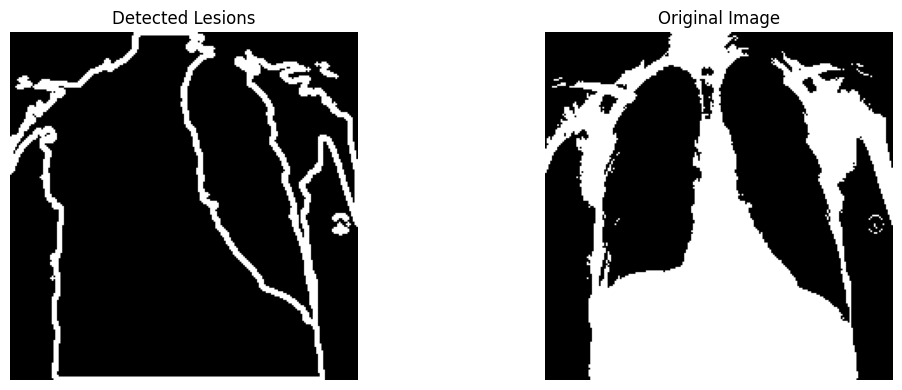

In [15]:
# Lung Segmentation (Example using thresholding)
def lung_segmentation(image):
    _, binary = cv2.threshold((image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
segmented_img = lung_segmentation(x[0].reshape(200, 200))
axes[0].imshow(segmented_img, cmap='gray')
axes[0].set_title('Segmented Lung Region')
axes[0].axis('off')
axes[1].imshow(x[0].reshape(200, 200), cmap='gray')
axes[1].set_title('Original Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Lesion Detection (Example using contours)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
contours, _ = cv2.findContours((x[0].reshape(200, 200) * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lesion_img = cv2.drawContours(np.zeros_like(x[0].reshape(200, 200)), contours, -1, (255), thickness=2)
axes[0].imshow(lesion_img, cmap='gray')
axes[0].set_title('Detected Lesions')
axes[0].axis('off')
axes[1].imshow(x[0].reshape(200, 200), cmap='gray')
axes[1].set_title('Original Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Lung Segmentation: This function identifies and isolates the lung region in a chest X-ray image. It achieves this by converting the image into a binary format, finding contours to outline the lung boundaries, creating a mask based on these contours, and then using bitwise operations to extract the lung region. The resulting segmented lung region is then displayed alongside the original image.

Lesion Detection: In this section, the code identifies any lesions or abnormalities present in the chest X-ray image. It does so by detecting contours, which represent the boundaries of potential lesions. These contours are then drawn onto a blank image, effectively highlighting the areas of interest. The detected lesions are then visualized alongside the original chest X-ray image for further analysis.


In [16]:
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [17]:
# Split the data into training and testing sets
#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions on the testing set
y_pred = rf_classifier.predict(x_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print('\nClassification Report:')
print(classification_report(y_val, y_pred))


Accuracy: 0.9371554575523704

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       700
           1       0.93      0.78      0.85       207

    accuracy                           0.94       907
   macro avg       0.93      0.88      0.91       907
weighted avg       0.94      0.94      0.94       907



In [19]:
#logistic regression model
from sklearn.linear_model import LogisticRegression
log_regression=LogisticRegression(max_iter=1000)
log_regression.fit(x_train_resampled, y_train_resampled)
y_pred = log_regression.predict(x_val)


# Calculate accuracy
accuracy_logreg = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_logreg)


Accuracy: 0.906284454244763


In [20]:
from sklearn.svm import SVC
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', gamma='scale')  # Using RBF kernel
svm_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions
y_pred = svm_classifier.predict(x_val)

# Calculate accuracy
accuracy_SVC = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_SVC)

Accuracy: 0.958103638368247


The Radial Basis Function (RBF) kernel is a kernel function used in support vector machine (SVM) classification. It's a popular kernel function used in various kernelized learning algorithms
The RBF kernel can be used with the SVM classifier to transform data into a higher-dimensional space. It's well-suited for data that is not linearly separable. 
The RBF kernel is defined by a single parameter, gamma, which determines the width of the kernel and therefore the complexity of the model. The RBF kernel is a polynomial of infinite power, making it a powerful kernel that can fit a curve to any complex dataset


In [21]:
from sklearn.svm import SVC
# Initialize and train the SVM classifier
svm_classifier =  SVC(kernel='linear') # Using linear  kernel
svm_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions
y_pred = svm_classifier.predict(x_val)

# Calculate accuracy
accuracy_SVC = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_SVC)

Accuracy: 0.918412348401323


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions
y_pred = tree_classifier.predict(x_val)

# Calculate accuracy
accuracy_DT = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_DT)

# Print the classification report
print('\nClassification Report:')
print(classification_report(y_val, y_pred))

Accuracy: 0.8478500551267916

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       700
           1       0.67      0.65      0.66       207

    accuracy                           0.85       907
   macro avg       0.79      0.78      0.78       907
weighted avg       0.85      0.85      0.85       907



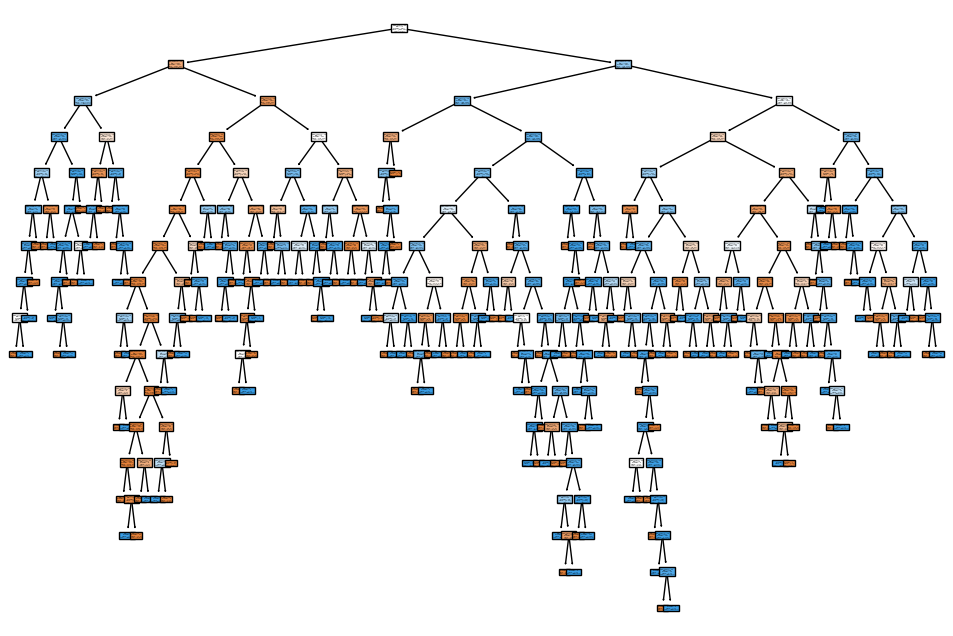

In [23]:
# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, filled=True, feature_names=[f'pixel_{i}' for i in range(x_train.shape[1])], class_names=list(classes.keys()))
plt.show()

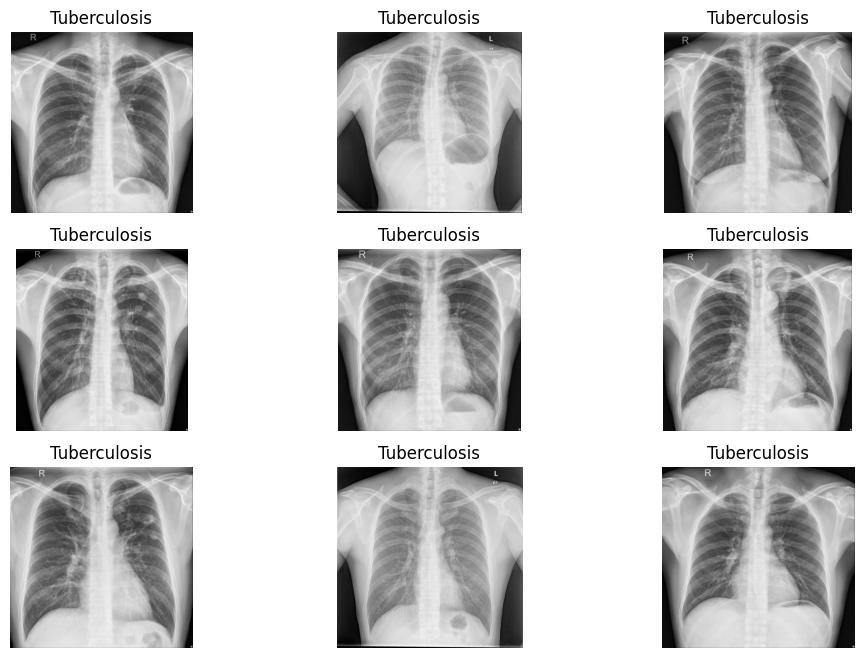

In [24]:
#Random forest classification  plotting of images
plt.figure(figsize=(12, 8))
c = 1
path = "D:/Joshwin/research papers/dataset/tuberculosis dataset/TB_Chest_Radiography_Database/tuberculosis"
classes = {'Normal': 0, 'Tuberculosis': 1}
for i in os.listdir(path)[:9]:
    img = cv2.imread(os.path.join(path, i), 0)
    if img is not None:
        p = rf_classifier.predict(cv2.resize(img, (200, 200)).reshape(1, -1))
        class_name = list(classes.keys())[list(classes.values()).index(p[0])]
        plt.subplot(3, 3, c)
        plt.title(class_name)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        c += 1
    else:
        print(f"Fail to load image: {i}")
plt.show()

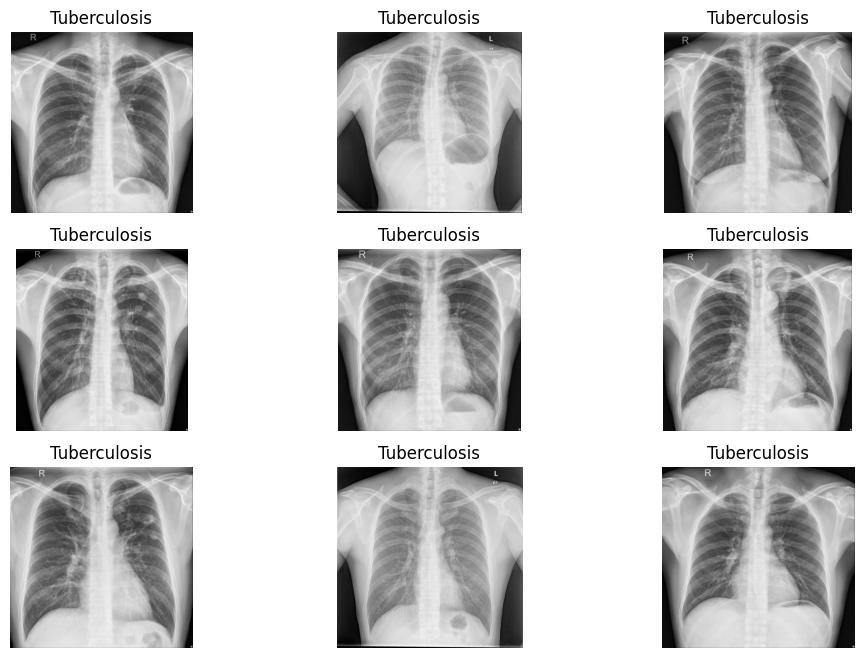

In [25]:
plt.figure(figsize=(12, 8))
c = 1
path = "D:/Joshwin/research papers/dataset/tuberculosis dataset/TB_Chest_Radiography_Database/Tuberculosis"
classes = {'Normal': 0, 'Tuberculosis': 1}

for i in os.listdir(path)[:9]:
    img = cv2.imread(os.path.join(path, i), 0)
    if img is not None:
        p = log_regression.predict(cv2.resize(img, (200, 200)).reshape(1, -1))
        class_name = list(classes.keys())[list(classes.values()).index(p[0])]
        plt.subplot(3, 3, c)
        plt.title(class_name)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        c += 1
    else:
        print(f"Fail to load image: {i}")
plt.show()

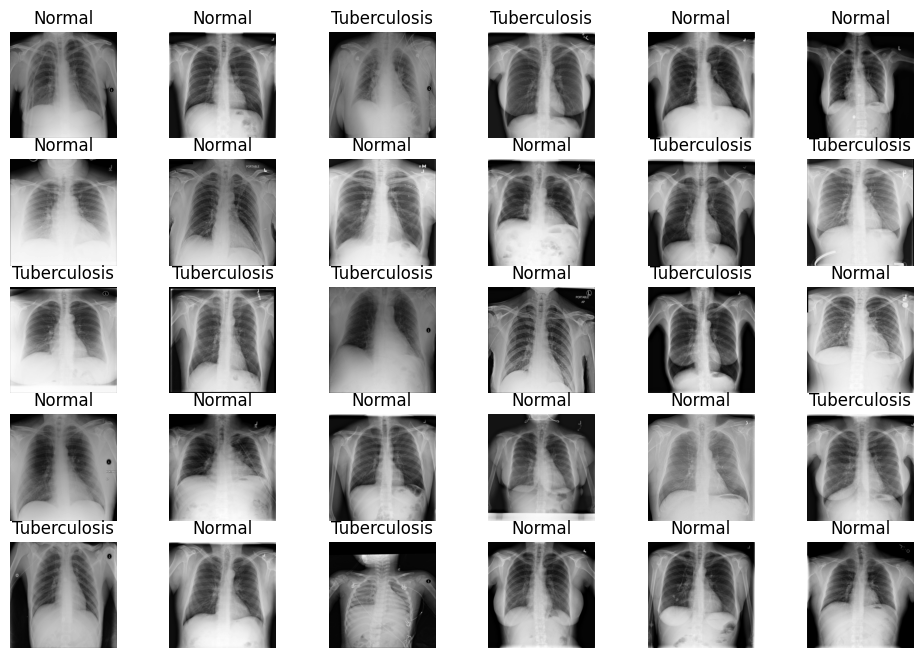

In [26]:
import os
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
c = 1
path = "D:/Joshwin/research papers/dataset/tuberculosis dataset/TB_Chest_Radiography_Database/Normal"
classes = {'Normal': 0, 'Tuberculosis': 1}

for i, filename in enumerate(os.listdir(path)[:30]):
    img = cv2.imread(os.path.join(path, filename), 0)
    if img is not None:
        p = svm_classifier.predict(cv2.resize(img, (200, 200)).reshape(1, -1))
        class_name = list(classes.keys())[list(classes.values()).index(p[0])]
        plt.subplot(5, 6, c)  # Adjust the subplot grid to accommodate 30 images
        plt.title(class_name)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        c += 1
    else:
        print(f"Fail to load image: {filename}")
plt.show()


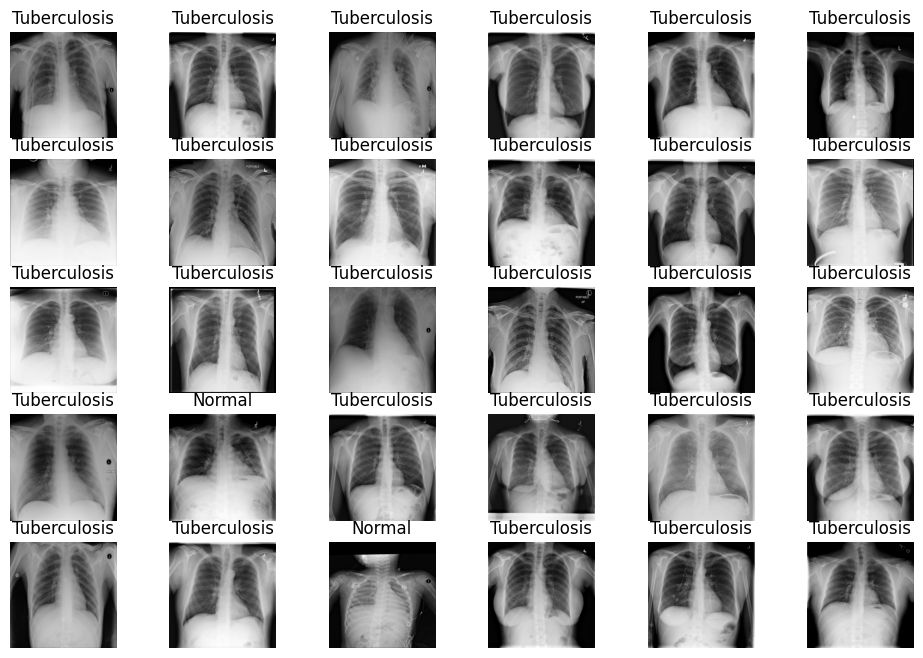

In [27]:
import os
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
c = 1
path = "D:/Joshwin/research papers/dataset/tuberculosis dataset/TB_Chest_Radiography_Database/Normal"
classes = {'Normal': 0, 'Tuberculosis': 1}

for i, filename in enumerate(os.listdir(path)[:30]):
    img = cv2.imread(os.path.join(path, filename), 0)
    if img is not None:
        p = tree_classifier.predict(cv2.resize(img, (200, 200)).reshape(1, -1))
        class_name = list(classes.keys())[list(classes.values()).index(p[0])]
        plt.subplot(5, 6, c)  # Adjust the subplot grid to accommodate 30 images
        plt.title(class_name)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        c += 1
    else:
        print(f"Fail to load image: {filename}")
plt.show()


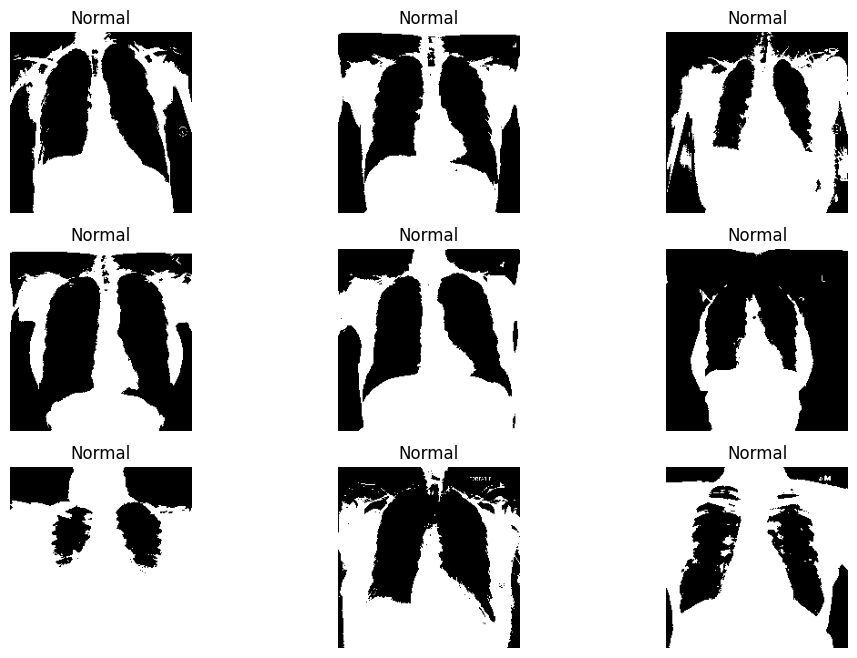

In [28]:
# Define path and classes
path = "D:/Joshwin/research papers/dataset/tuberculosis dataset/TB_Chest_Radiography_Database"
classes = {0: 'Normal', 1: 'Tuberculosis'}

# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path, 0)
    if img is not None:
        img = cv2.resize(img, (200, 200))
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
        return img.flatten()
    else:
        return None

# Plot images with predictions
plt.figure(figsize=(12, 8))
c = 1
for i, img_name in enumerate(os.listdir(os.path.join(path, 'Normal'))[:9], 1):
    img_path = os.path.join(path, 'Normal', img_name)
    img = preprocess_image(img_path)
    if img is not None:
        prediction = svm_classifier.predict([img])
        predicted_class = classes[prediction[0]]
        plt.subplot(3, 3, c)
        plt.title(predicted_class)
        plt.imshow(img.reshape(200, 200), cmap='gray')
        plt.axis('off')
        c += 1
plt.show()


Accuracy: 0.9371554575523704


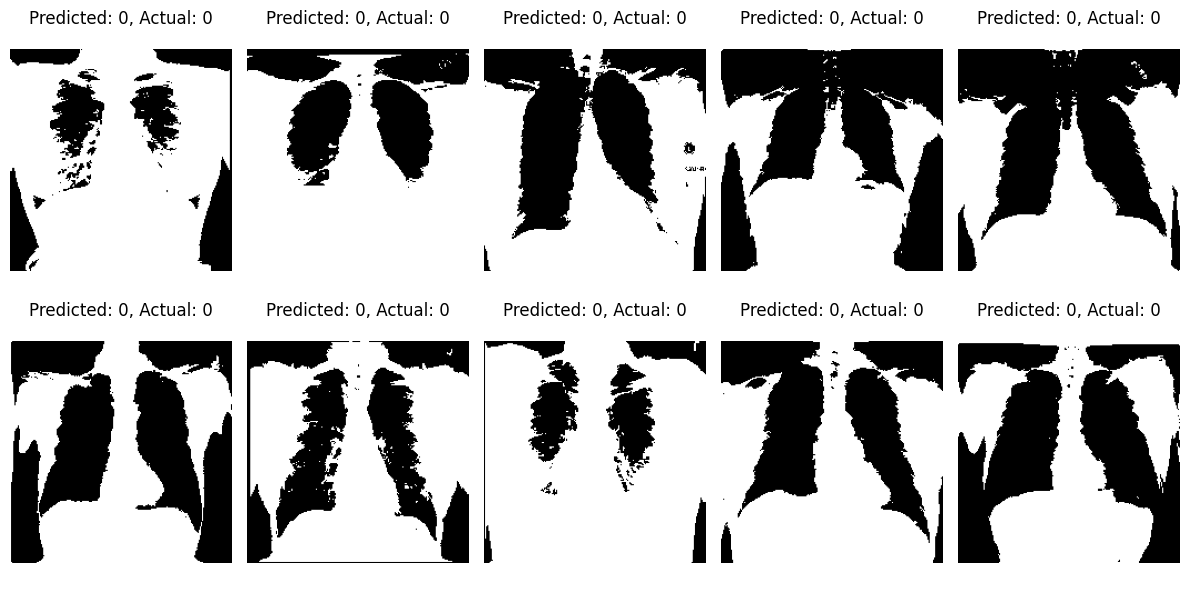


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       700
           1       0.93      0.78      0.85       207

    accuracy                           0.94       907
   macro avg       0.93      0.88      0.91       907
weighted avg       0.94      0.94      0.94       907



In [29]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions on the testing set
y_pred = rf_classifier.predict(x_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# Plot example features and images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Reshape the data into a square shape
    square_data = np.reshape(x_val[i], (200, 200))  # Assuming 200x200 is a suitable square shape
    ax_image = ax.twinx()  # Create a twin Axes sharing the xaxis
    ax_image.imshow(square_data, cmap='gray')
    ax_image.axis('off')  # Turn off axis for images
    ax.set_title(f'Predicted: {y_pred[i]}, Actual: {y_val[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Print the classification report
print('\nClassification Report:')
print(classification_report(y_val, y_pred))


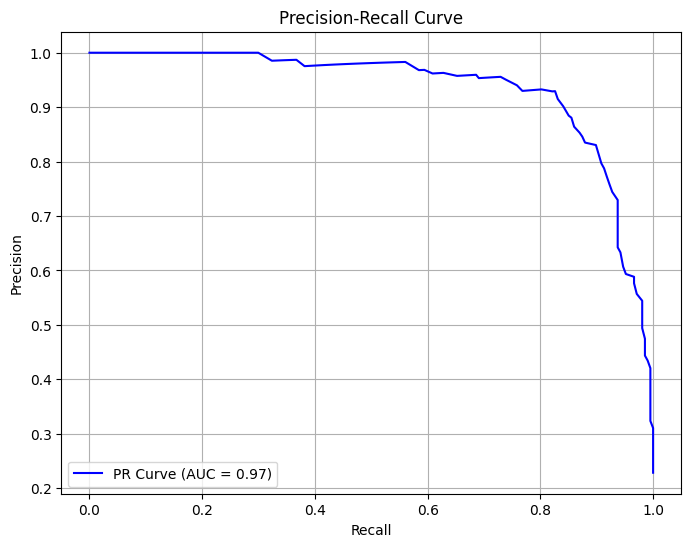

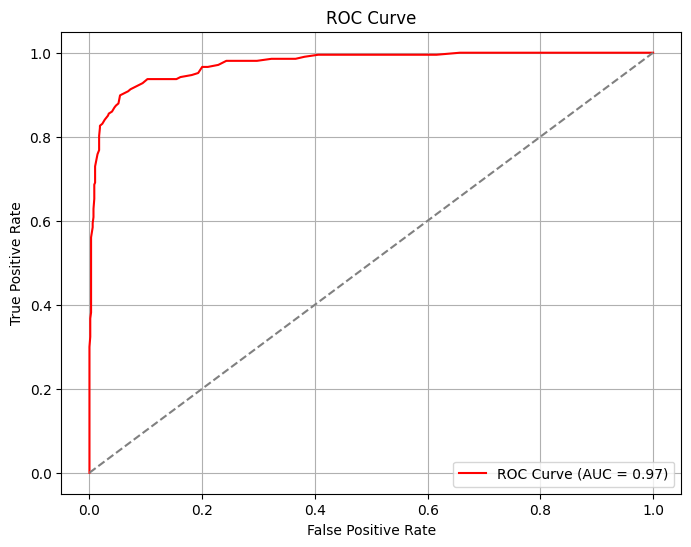

In [30]:
from sklearn.metrics import precision_recall_curve,roc_curve,auc
# Predict probabilities
y_probs = rf_classifier.predict_proba(x_val)[:, 1]

# Compute Precision-Recall and ROC curve and area under the curves
precision, recall, _ = precision_recall_curve(y_val, y_probs)
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {roc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

the precision recall curve -gives the model  highly precise positive predictions but with low recall (missing many true positives).As the recall increases (moving towards the right side of the curve), the precision gradually decreases, which is expected since lowering the threshold captures more true positives but also introduces more false positives


Accuracy: 0.906284454244763


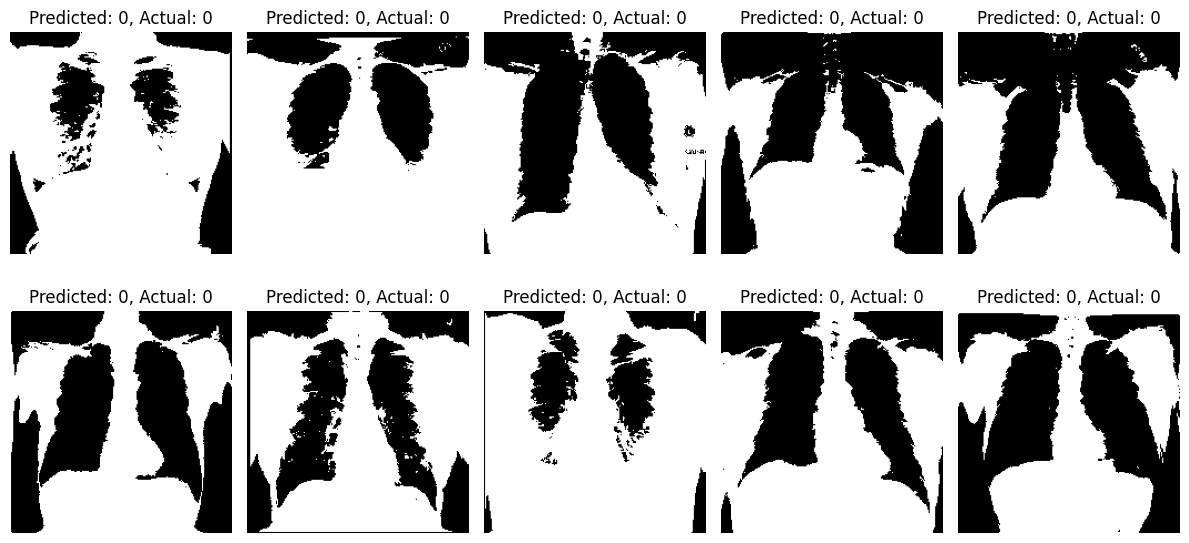


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       700
           1       0.82      0.76      0.79       207

    accuracy                           0.91       907
   macro avg       0.87      0.85      0.86       907
weighted avg       0.90      0.91      0.91       907



In [31]:
# Logistic Regression model
log_regression = LogisticRegression(max_iter=1000)
log_regression.fit(x_train_resampled, y_train_resampled)

# Predictions
y_pred = log_regression.predict(x_val)

# Calculate accuracy
accuracy_logreg = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_logreg)

# Plot example images and print accuracy
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Reshape the data into a square shape or any other compatible shape
    img_shape = (int(np.sqrt(x_val.shape[1])), int(np.sqrt(x_val.shape[1])))  # Assuming square images
    square_data = np.reshape(x_val[i], img_shape)
    ax.imshow(square_data, cmap='gray')
    ax.set_title(f'Predicted: {y_pred[i]}, Actual: {y_val[i]}')
    ax.axis('off')  # Turn off axis for images

plt.tight_layout()
plt.show()

# Print the classification report
print('\nClassification Report:')
print(classification_report(y_val, y_pred))

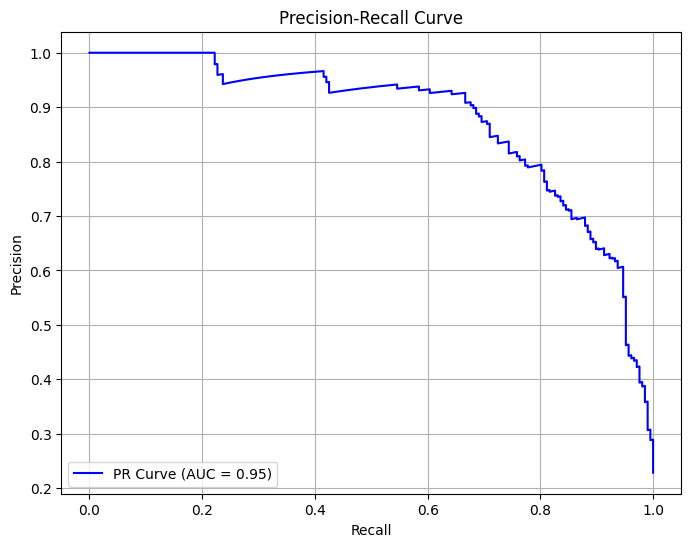

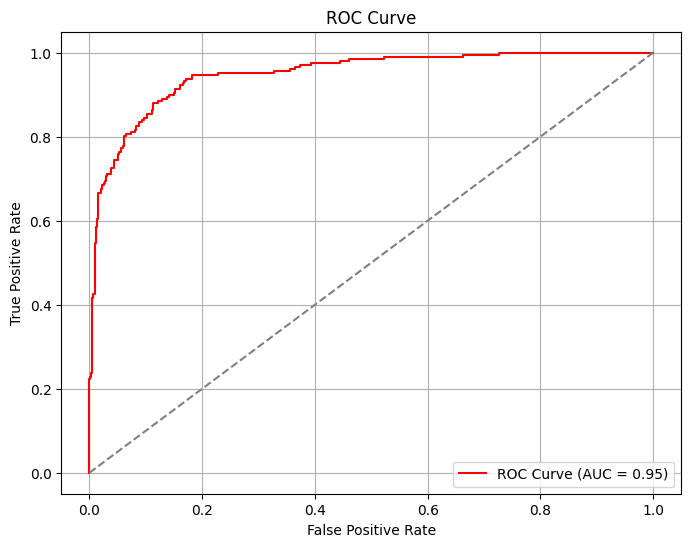

In [32]:
y_probs = log_regression.predict_proba(x_val)[:, 1]

# Compute Precision-Recall and ROC curve and area under the curves
precision, recall, _ = precision_recall_curve(y_val, y_probs)
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {roc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Accuracy: 0.958103638368247


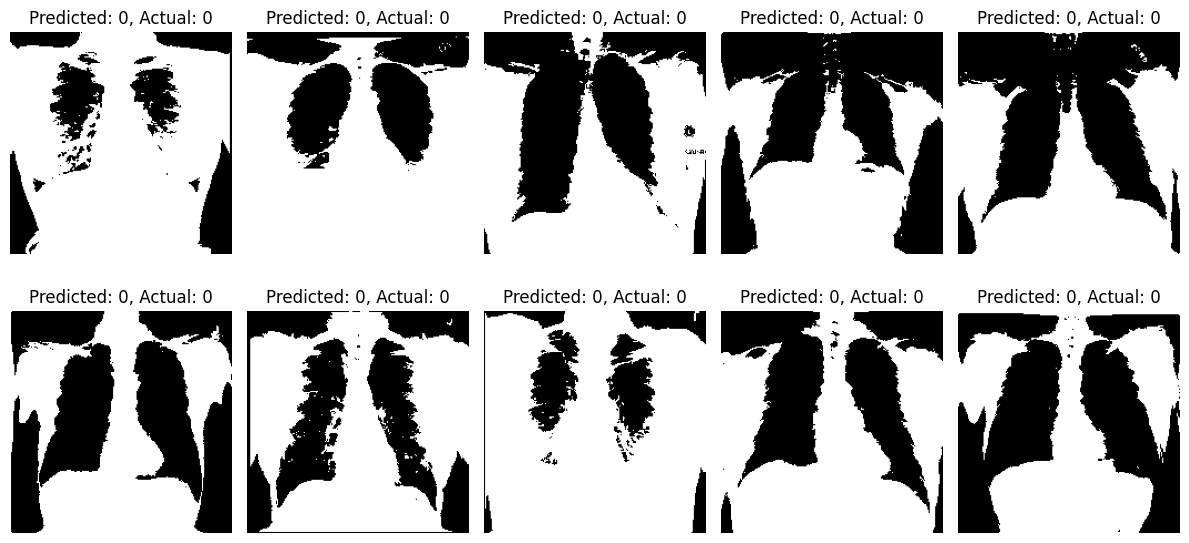


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       700
           1       0.91      0.91      0.91       207

    accuracy                           0.96       907
   macro avg       0.94      0.94      0.94       907
weighted avg       0.96      0.96      0.96       907



In [33]:
# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='rbf', gamma='scale')  # Using RBF kernel
svm_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions
y_pred = svm_classifier.predict(x_val)

# Calculate accuracy
accuracy_SVC = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy_SVC)

# Plot example images and print accuracy
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Reshape the data into a square shape or any other compatible shape
    img_shape = (int(np.sqrt(x_val.shape[1])), int(np.sqrt(x_val.shape[1])))  # Assuming square images
    square_data = np.reshape(x_val[i], img_shape)
    ax.imshow(square_data, cmap='gray')
    ax.set_title(f'Predicted: {y_pred[i]}, Actual: {y_val[i]}')
    ax.axis('off')  # Turn off axis for images

plt.tight_layout()
plt.show()

# Print the classification report
print('\nClassification Report:')
print(classification_report(y_val, y_pred))

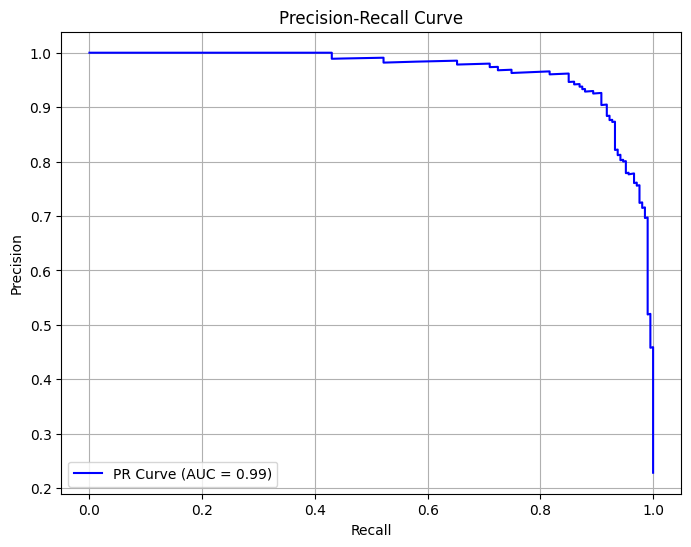

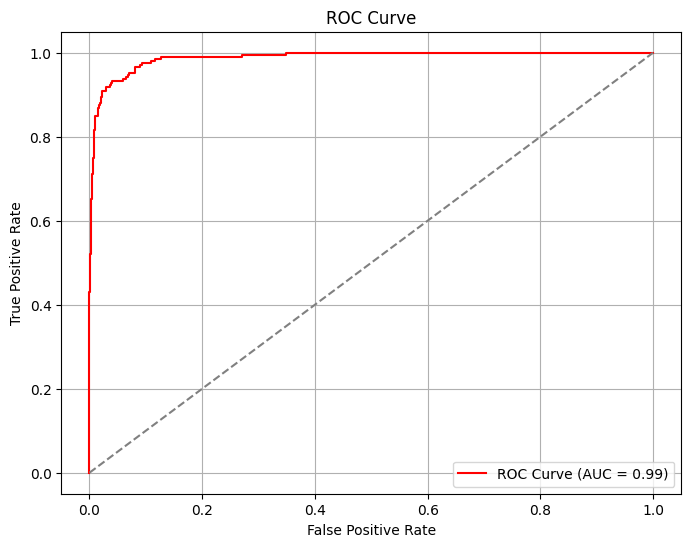

In [34]:
# Predict probabilities
y_probs = svm_classifier.decision_function(x_val)

# Compute Precision-Recall and ROC curve and area under the curves
precision, recall, _ = precision_recall_curve(y_val, y_probs)
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {roc_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

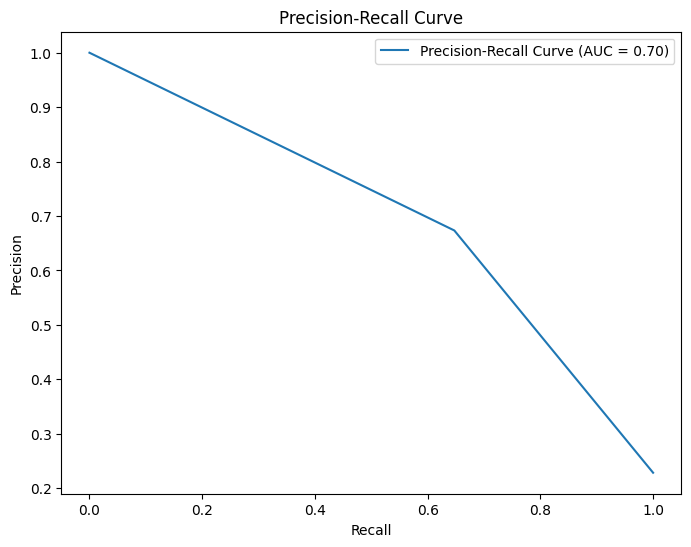

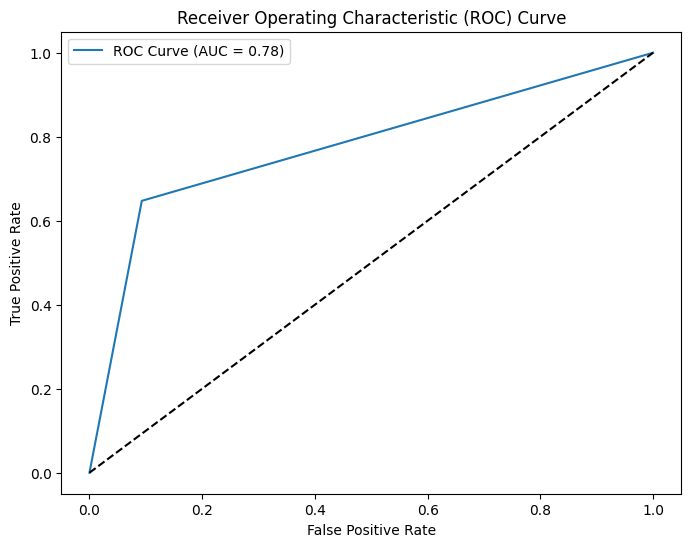

In [35]:
# Create a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model on the oversampled data
dt_classifier.fit(x_train_resampled, y_train_resampled)

# Make predictions on the testing set
y_pred_proba = dt_classifier.predict_proba(x_val)[:, 1]  # Get probability scores for the positive class

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)

# Calculate area under the precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Calculate area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [36]:
#implementation of CNN  for image classification
#ResNet and #VGG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import numpy as np

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model architecture
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape the input data for the CNN model
x_train_cnn = x_train_resampled.reshape(-1, 200, 200, 1)
x_val_cnn = x_val.reshape(-1, 200, 200, 1)

# Data augmentation
x_train_augmented = data_generator.flow(x_train_cnn, y_train_resampled, batch_size=32)

# Train the model
history = model.fit(x_train_augmented, epochs=20, validation_data=(x_val_cnn, y_val))

# Evaluate the model on the validation set
y_pred = model.predict(x_val_cnn)
y_pred = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Append the evaluation scores to the lists
accuracies.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)

# Print the average evaluation scores
print(f"Average accuracy: {np.mean(accuracies):.4f}")
print(f"Average precision: {np.mean(precisions):.4f}")
print(f"Average recall: {np.mean(recalls):.4f}")
print(f"Average F1-score: {np.mean(f1_scores):.4f}")

c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 67s 361ms/step - accuracy: 0.6094 - loss: 0.6495 - val_accuracy: 0.8181 - val_loss: 0.4252
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 348ms/step - accuracy: 0.7490 - loss: 0.5492 - val_accuracy: 0.8093 - val_loss: 0.4163
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 350ms/step - accuracy: 0.7586 - loss: 0.5167 - val_accuracy: 0.8501 - val_loss: 0.3185
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 349ms/step - accuracy: 0.7767 - loss: 0.4764 - val_accuracy: 0.8467 - val_loss: 0.3401
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 346ms/step - accuracy: 0.7860 - loss: 0.4572 - val_accuracy: 0.8611 - val_loss: 0.3126
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 351ms/step - accuracy: 0.8066 - loss: 0.4450 - val_accuracy: 0.8842 - val_loss: 0.2845
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 348ms/step - accuracy: 0.8062 - loss: 0.4337 - val_accuracy: 0.8743 - val_loss: 0.2800
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 67s 376ms/step - accuracy: 0.8110 - loss: 0.4106 - val

In [41]:
print(accuracy)

0.8434399117971334


In [44]:
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
